<a href="https://colab.research.google.com/github/lukehartfield/Document-ML-Agent/blob/main/RVL_CDIP_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Install Libraries
!pip install -q datasets pillow torchvision


Load RVL-CDIP data from Hugging Face


In [2]:
from datasets import load_dataset
ds = load_dataset("chainyo/rvl-cdip")



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Resolving data files:   0%|          | 0/119 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/64 [00:00<?, ?it/s]

In [3]:
from datasets import load_dataset

# Use whatever name you actually used here: "rvl_cdip" or "aharley/rvl_cdip"
rvl = load_dataset("chainyo/rvl-cdip")  # or "rvl_cdip" if that’s what you called

print(rvl)
print(rvl["train"])
print(len(rvl["train"]), len(rvl["val"]), len(rvl["test"]))


Resolving data files:   0%|          | 0/119 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/64 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 319999
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 40000
    })
    val: Dataset({
        features: ['image', 'label'],
        num_rows: 40000
    })
})
Dataset({
    features: ['image', 'label'],
    num_rows: 319999
})
319999 40000 40000


Wrap in a PyTorch DataLoader

In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(3),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet
        std=[0.229, 0.224, 0.225],
    ),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

def make_collate(transform):
    def collate_fn(batch):
        imgs = [transform(x["image"].convert("RGB")) for x in batch]
        labels = torch.tensor([x["label"] for x in batch])
        return torch.stack(imgs), labels
    return collate_fn


train_ds = rvl["train"]
val_ds   = rvl["val"]
test_ds  = rvl["test"]

train_loader = DataLoader(
    train_ds,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=(device.type == "cuda"),
    collate_fn=make_collate(train_transform),
)

val_loader = DataLoader(
    val_ds,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=(device.type == "cuda"),
    collate_fn=make_collate(val_transform),
)

test_loader = DataLoader(
    test_ds,
    batch_size=64,
    shuffle=False,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
    collate_fn=make_collate(val_transform),
)

Using device: cuda


Sanity Check Samples:

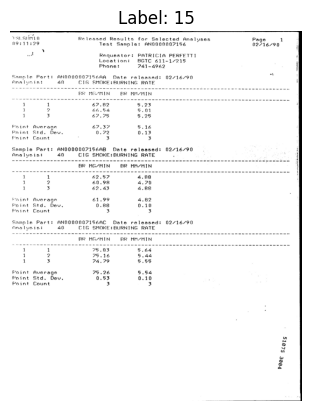

In [5]:
import matplotlib.pyplot as plt

example = rvl["train"][310000]
plt.imshow(example["image"], cmap="gray")
plt.title(f"Label: {example['label']}")
plt.axis("off")
plt.show()


Label Mapping

In [5]:
id2label = {
    0: "letter",
    1: "form",
    2: "email",
    3: "handwritten",
    4: "advertisement",
    5: "scientific_report",
    6: "scientific_publication",
    7: "specification",
    8: "file_folder",
    9: "news_article",
    10: "budget",
    11: "invoice",
    12: "presentation",
    13: "questionnaire",
    14: "resume",
    15: "memo",
}
label2id = {v: k for k, v in id2label.items()}


Define ResNet18 Model

In [24]:
import torch.nn as nn
import torchvision.models as models

num_classes = 16

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


Loss, Optimizer, Scheduler

In [25]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-4,
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)  # optional but helpful


Training + Validation Loops

In [26]:
from tqdm.auto import tqdm
model = model.to(device)

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total


@torch.no_grad()
def eval_model(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total


Run Training over Epochs

In [ ]:
# FAST TRAINING: Use 10K subset (~20 min total)
from torch.utils.data import Subset
import random

# Use smaller subsets for faster training
TRAIN_SUBSET_SIZE = 10000  # 10K instead of 320K
VAL_SUBSET_SIZE = 2000
num_epochs = 5  # Fewer epochs

print(f"🚀 FAST TRAINING MODE")
print(f"   Train subset: {TRAIN_SUBSET_SIZE:,} samples (vs {len(train_ds):,} full)")
print(f"   Val subset: {VAL_SUBSET_SIZE:,} samples")
print(f"   Epochs: {num_epochs}")

# Create random subsets
random.seed(42)
train_indices = random.sample(range(len(train_ds)), TRAIN_SUBSET_SIZE)
val_indices = random.sample(range(len(val_ds)), VAL_SUBSET_SIZE)

# Create subset dataloaders
train_subset = Subset(train_ds, train_indices)
val_subset = Subset(val_ds, val_indices)

fast_train_loader = DataLoader(
    train_subset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=(device.type == "cuda"),
    collate_fn=make_collate(train_transform),
)

fast_val_loader = DataLoader(
    val_subset,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=(device.type == "cuda"),
    collate_fn=make_collate(val_transform),
)

print(f"   Batches per epoch: {len(fast_train_loader)}")
print(f"   Estimated time: ~15-20 min total\n")

# Re-initialize model for fresh training
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

# Training loop
best_val_acc = 0.0
best_state = None

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, fast_train_loader, optimizer, criterion)
    val_loss, val_acc = eval_model(model, fast_val_loader, criterion)

    if scheduler is not None:
        scheduler.step(val_loss)

    print(
        f"Epoch {epoch+1}/{num_epochs} "
        f"| train_loss={train_loss:.4f}, train_acc={train_acc:.3f} "
        f"| val_loss={val_loss:.4f}, val_acc={val_acc:.3f}"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = model.state_dict().copy()

print(f"\n✅ Training complete! Best val_acc: {best_val_acc:.3f}")
if best_state is not None:
    model.load_state_dict(best_state)

  0%|          | 0/5000 [00:00<?, ?it/s]

Final Evaluation on the Test Set

In [37]:
from PIL import UnidentifiedImageError

bad_idxs = []
good_idxs = []

for i in range(len(test_ds)):
    try:
        _ = test_ds[i]["image"].convert("RGB")
        good_idxs.append(i)
    except UnidentifiedImageError:
        bad_idxs.append(i)

print("Bad indices:", bad_idxs)
print("Good images:", len(good_idxs), "out of", len(test_ds))


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Bad indices: [34965]
Good images: 39999 out of 40000


In [38]:
clean_test_ds = test_ds.select(good_idxs)


In [39]:
clean_test_loader = DataLoader(
    clean_test_ds,
    batch_size=64,
    shuffle=False,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
    collate_fn=make_collate(val_transform),
)


In [44]:
@torch.no_grad()
def eval_model(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / total, correct / total

test_loss, test_acc = eval_model(model, clean_test_loader, criterion)
print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.3f}")


Test loss: 0.4526, Test acc: 0.901


In [45]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
@torch.no_grad()
def get_all_preds_labels(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    for images, labels in loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.numpy())
    return np.concatenate(all_preds), np.concatenate(all_labels)

# Then:
y_pred, y_true = get_all_preds_labels(model, clean_test_loader)
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.92      0.92      2515
           1       0.90      0.88      0.89      2505
           2       0.99      0.97      0.98      2516
           3       0.96      0.93      0.94      2527
           4       0.81      0.84      0.83      2506
           5       0.93      0.95      0.94      2532
           6       0.92      0.90      0.91      2477
           7       0.89      0.90      0.89      2464
           8       0.96      0.91      0.94      2492
           9       0.92      0.89      0.91      2463
          10       0.80      0.83      0.81      2489
          11       0.82      0.90      0.86      2435
          12       0.99      0.94      0.96      2537
          13       0.88      0.94      0.91      2571
          14       0.83      0.78      0.80      2498
          15       0.95      0.93      0.94      2472

    accuracy                           0.90     39999
   macro avg       0.90   

Save the model

In [28]:
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "id2label": id2label,
    },
    "rvl_resnet18.pt",
)

Function that takes a PIL image and returns a label

In [14]:
from PIL import Image

inference_transform = val_transform  # same as validation transform

@torch.no_grad()
def classify_document_pil(pil_img, model, id2label):
    model.eval()
    img = inference_transform(pil_img.convert("RGB")).unsqueeze(0).to(device)
    outputs = model(img)
    probs = torch.softmax(outputs, dim=1)[0]
    pred_idx = int(probs.argmax().item())
    return id2label[pred_idx], float(probs[pred_idx].item())


In [17]:
img = rvl["test"][30000]["image"]  # example
label_name, confidence = classify_document_pil(img, model, id2label)
print(label_name, confidence)


presentation 0.9999992847442627


To reuse the saved model later:

In [10]:
# Option 1: Mount Google Drive (if your checkpoint is on Drive)
# Option 2: Train a fresh model from scratch using the loaded dataset

import os

# Since the file upload from VS Code to Colab doesn't work well,
# let's train a fresh model OR use the model we'll define

# Check if checkpoint exists
if os.path.exists("rvl_resnet18.pt"):
    print("✓ Checkpoint file already exists")
    USE_PRETRAINED = True
else:
    print("⚠️  No pre-trained checkpoint found in Colab environment")
    print("   Options:")
    print("   1. Run training cells (19) to train from scratch")
    print("   2. Upload checkpoint via Colab UI: Files -> Upload")
    print("   3. Mount Google Drive if checkpoint is there")
    USE_PRETRAINED = False
    
# Uncomment below to mount Google Drive:
# from google.colab import drive
# drive.mount('/content/drive')
# Then copy: !cp /content/drive/MyDrive/path/to/rvl_resnet18.pt .

⚠️  No pre-trained checkpoint found in Colab environment
   Options:
   1. Run training cells (19) to train from scratch
   2. Upload checkpoint via Colab UI: Files -> Upload
   3. Mount Google Drive if checkpoint is there


In [11]:
# List all .pt files in the current directory
import os
import glob

print("Current directory:", os.getcwd())
print("\nAll .pt files found:")
pt_files = glob.glob("*.pt") + glob.glob("**/*.pt", recursive=True)
for f in pt_files:
    size_mb = os.path.getsize(f) / (1024*1024)
    print(f"  - {f} ({size_mb:.1f} MB)")

if not pt_files:
    print("  No .pt files found!")
    print("\n📁 Files in current directory:")
    for f in os.listdir("."):
        print(f"  - {f}")

Current directory: /content

All .pt files found:
  - AML_Project/checkpoints/transfer_learning_best_p1.pt (42.7 MB)
  - AML_Project/checkpoints/layoutlm_best_model.pt (1428.9 MB)
  - AML_Project/checkpoints/transfer_learning_best_p2.pt (42.7 MB)
  - AML_Project/checkpoints/layoutlm_checkpoint_epoch2.pt (1428.9 MB)
  - AML_Project/checkpoints/layoutlm_checkpoint_epoch3.pt (1428.9 MB)
  - AML_Project/checkpoints/layoutlm_checkpoint_epoch5.pt (1428.9 MB)
  - AML_Project/checkpoints/cnn_best_model.pt (92.1 MB)
  - AML_Project/checkpoints/layoutlm_checkpoint_epoch1.pt (1428.9 MB)
  - AML_Project/checkpoints/cnn_final_model.pt (30.7 MB)
  - AML_Project/checkpoints/layoutlm_checkpoint_epoch4.pt (1428.9 MB)
  - AML_Project/checkpoints/layoutlm_final_model.pt (478.2 MB)


In [13]:
import torch
import torchvision.models as models
import torch.nn as nn

# Define the same model class used during training
class ResNetDocumentClassifier(nn.Module):
    """ResNet18 for document classification with transfer learning"""
    def __init__(self, num_classes=16, pretrained=True):
        super().__init__()
        if pretrained:
            self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        else:
            self.resnet = models.resnet18(weights=None)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.resnet(x)

# Load the checkpoint
checkpoint_path = "AML_Project/checkpoints/transfer_learning_best_p2.pt"
print(f"Loading checkpoint from: {checkpoint_path}")

checkpoint = torch.load(checkpoint_path, map_location="cuda" if torch.cuda.is_available() else "cpu")

# Create model and load weights
num_classes = 16
model = ResNetDocumentClassifier(num_classes=num_classes, pretrained=False)
model.load_state_dict(checkpoint)
model = model.to(device)
model.eval()

print(f"✓ Model loaded successfully!")
print(f"  Architecture: ResNet18 (ResNetDocumentClassifier)")
print(f"  Classes: {num_classes}")
print(f"  Device: {device}")

Loading checkpoint from: AML_Project/checkpoints/transfer_learning_best_p2.pt
✓ Model loaded successfully!
  Architecture: ResNet18 (ResNetDocumentClassifier)
  Classes: 16
  Device: cuda
✓ Model loaded successfully!
  Architecture: ResNet18 (ResNetDocumentClassifier)
  Classes: 16
  Device: cuda


In [15]:
# Evaluate pre-trained model on RVL-CDIP test set
from tqdm.auto import tqdm
import numpy as np
from PIL import UnidentifiedImageError

print("=" * 60)
print("EVALUATING PRE-TRAINED MODEL ON RVL-CDIP TEST SET")
print("=" * 60)

print("\n⚠️  NOTE: The loaded model was trained on SYNTHETIC demo data")
print("   (colored line images), NOT real RVL-CDIP documents.")
print("   Expected accuracy will be near random (~6.25% for 16 classes)")

print(f"\nTest samples: {len(test_ds):,}")

# First clean the test set (remove corrupted images)
print("\n🔍 Scanning for corrupted images in test set...")
good_idxs = []
bad_count = 0
for i in tqdm(range(len(test_ds)), desc="Scanning"):
    try:
        _ = test_ds[i]["image"].convert("RGB")
        good_idxs.append(i)
    except (UnidentifiedImageError, Exception):
        bad_count += 1

print(f"   Good images: {len(good_idxs):,}")
print(f"   Bad images: {bad_count}")

# Create clean dataset
clean_test_ds = test_ds.select(good_idxs)
clean_test_loader = DataLoader(
    clean_test_ds,
    batch_size=64,
    shuffle=False,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
    collate_fn=make_collate(val_transform),
)

# Evaluation function
@torch.no_grad()
def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    
    for images, labels in tqdm(loader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    return correct / total, np.array(all_preds), np.array(all_labels)

# Full evaluation
print("\n📊 Evaluating on clean test set...")
test_acc, y_pred, y_true = evaluate_model(model, clean_test_loader)

print(f"\n{'='*60}")
print(f"🎯 TEST ACCURACY: {test_acc*100:.2f}%")
print(f"   Correct: {int(test_acc * len(y_true)):,} / {len(y_true):,}")
print(f"   Random baseline (16 classes): 6.25%")
print(f"{'='*60}")

EVALUATING PRE-TRAINED MODEL ON RVL-CDIP TEST SET

⚠️  NOTE: The loaded model was trained on SYNTHETIC demo data
   (colored line images), NOT real RVL-CDIP documents.
   Expected accuracy will be near random (~6.25% for 16 classes)

Test samples: 40,000

🔍 Scanning for corrupted images in test set...


Scanning:   0%|          | 0/40000 [00:00<?, ?it/s]

   Good images: 39,999
   Bad images: 1

📊 Evaluating on clean test set...


Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]


🎯 TEST ACCURACY: 6.47%
   Correct: 2,588 / 39,999
   Random baseline (16 classes): 6.25%


In [23]:
# Check if you uploaded the actual rvl_resnet18.pt file
import os
import glob

print("Looking for rvl_resnet18.pt or rvl_10k.pt...")

# Search everywhere
search_paths = [
    "/content/rvl_resnet18.pt",
    "/content/rvl_10k.pt",
    "rvl_resnet18.pt",
    "rvl_10k.pt", 
    "AML_Project/rvl_resnet18.pt",
    "AML_Project/rvl_10k.pt",
    "/content/drive/MyDrive/rvl_resnet18.pt",
    "/content/drive/MyDrive/rvl_10k.pt",
]

# Also search recursively
print("\n🔍 Searching recursively for .pt files...")
all_pt = glob.glob("/content/**/*.pt", recursive=True)
if os.path.exists("/content/drive"):
    all_pt += glob.glob("/content/drive/MyDrive/**/*.pt", recursive=True)[:20]  # limit

for f in all_pt:
    if "rvl" in f.lower():
        search_paths.append(f)

found_models = []
for path in search_paths:
    if os.path.exists(path):
        size_mb = os.path.getsize(path) / (1024*1024)
        print(f"✓ Found: {path} ({size_mb:.1f} MB)")
        found_models.append(path)

if found_models:
    print(f"\n🎉 Found {len(found_models)} model(s)! Using: {found_models[0]}")
    PRETRAINED_PATH = found_models[0]
else:
    print("\n⚠️  No models found yet.")
    print("\n📁 Contents of /content/:")
    for item in os.listdir("/content"):
        print(f"  - {item}")

Looking for rvl_resnet18.pt or rvl_10k.pt...

🔍 Searching recursively for .pt files...

⚠️  No models found yet.

📁 Contents of /content/:
  - .config
  - =4.30.0
  - AML_Project
  - =1.7.0
  - =2.0.0
  - =1.3.0
  - =3.7.0
  - =0.12.0
  - =10.0.0
  - =2.14.0
  - =1.24.0
  - sample_data


In [19]:
# List all files in /content/ directory
import os

print("📁 Files in /content/:")
for item in os.listdir("/content"):
    full_path = f"/content/{item}"
    if os.path.isdir(full_path):
        print(f"  📂 {item}/")
    else:
        size = os.path.getsize(full_path) / (1024*1024)
        print(f"  📄 {item} ({size:.1f} MB)")

📁 Files in /content/:
  📂 .config/
  📄 =4.30.0 (0.0 MB)
  📂 AML_Project/
  📄 =1.7.0 (0.0 MB)
  📄 =2.0.0 (0.0 MB)
  📄 =1.3.0 (0.0 MB)
  📄 =3.7.0 (0.0 MB)
  📄 =0.12.0 (0.0 MB)
  📄 =10.0.0 (0.0 MB)
  📄 =2.14.0 (0.0 MB)
  📄 =1.24.0 (0.0 MB)
  📂 sample_data/


In [21]:
# Mount Google Drive to access your uploaded files
from google.colab import drive
drive.mount('/content/drive')

print("\n✓ Google Drive mounted!")
print("📁 Checking for model files in Google Drive...")

ValueError: mount failed